# Introdução ao Variational Autoencoder (VAE)

O Variational Autoencoder, ou VAE, é uma poderosa técnica de aprendizado de máquina que combina elementos de redes neurais e modelos probabilísticos. Ele desempenha um papel fundamental na área de Inteligência Artificial (IA) e tem aplicações em diversas áreas, incluindo reconhecimento de padrões, geração de imagens, tradução automática e muito mais.

## O que é um Autoencoder?

Antes de mergulharmos no VAE, é importante entender o conceito de autoencoder. Um autoencoder é uma arquitetura de rede neural que visa aprender uma representação compacta e informativa dos dados de entrada. Consiste em duas partes principais:

* Encoder: Esta parte da rede transforma os dados de entrada em uma representação latente de menor dimensionalidade. Em outras palavras, comprime os dados em um espaço menor.

* Decoder: O decoder reconstrói os dados a partir da representação latente, tentando reproduzir os dados de entrada o mais fielmente possível.

O objetivo principal de um autoencoder é minimizar a diferença entre os dados de entrada e a saída reconstruída, forçando assim o modelo a aprender uma representação eficaz dos dados.

## A Inovação do Variational Autoencoder (VAE)

O VAE é uma evolução do autoencoder tradicional que introduz um componente probabilístico. Em vez de mapear diretamente os dados de entrada para uma representação latente, o VAE mapeia os dados para uma distribuição de probabilidade no espaço latente. Isso significa que, em vez de obter uma única representação latente, o VAE fornece uma distribuição de representações possíveis.

Isso é extremamente valioso porque permite ao VAE gerar novas amostras que são semelhantes aos dados de treinamento. Além disso, ele introduz uma interpretação probabilística em seu processo de codificação, o que pode ser útil em tarefas que envolvem incerteza, como na geração de texto ou imagens.

![1](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*kXiln_TbF15oVg7AjcUEkQ.png)

## Aplicações do VAE

O Variational Autoencoder é amplamente utilizado em várias aplicações de IA, incluindo:

* **Geração de Imagens**: O VAE pode gerar imagens semelhantes às do conjunto de treinamento, o que é útil em design gráfico e criação de conteúdo.

* **Reconhecimento de Anomalias**: Pode ser usado para identificar anomalias em dados, detectando discrepâncias significativas entre a entrada e a reconstrução.

* **Tradução Automática**: O VAE pode ser aplicado a tarefas de tradução automática, onde a incerteza nas traduções é uma consideração importante.

* **Modelagem de Dados Latentes**: É uma ferramenta valiosa para aprender representações latentes em conjuntos de dados complexos.

 ## Importação de Bibliotecas

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt


## Carregar o Conjunto de Dados MNIST

As imagens são normalizadas dividindo por 255.0 para escalar os valores de pixel entre 0 e 1. Em seguida, as imagens são remodeladas para o formato adequado (28x28 pixels com um único canal de cor).

In [20]:
# Carregar o conjunto de dados MNIST (ou qualquer outro conjunto de dados de sua escolha)
(x_train, _), (x_test, _) = mnist.load_data()

# Normalizar e remodelar os dados de entrada
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), 28, 28, 1))
x_test = x_test.reshape((len(x_test), 28, 28, 1))


## Definir o Codificador

O fluxo do encoder começa com as entradas do codificador, passa por camadas de convolução e redes neurais densas para aprender uma representação latente das imagens.

As médias (z_mean) e os desvios padrão (z_log_var) da distribuição latente são calculados a partir das camadas densas.

In [21]:
# Define o codificador
input_shape = (28, 28, 1)
latent_dim = 6

encoder_inputs = keras.Input(shape=input_shape)
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)


## Função de Amostragem da Distribuição Latente

Essa distribuição recebe as médias e os desvios padrão da distribuição latente e amostra valores latentes usando a técnica de reparametrização.

In [22]:
# Função de amostragem da distribuição latente
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], latent_dim), mean=0.0, stddev=1.0)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])


## Definir o Decodificador

Aqui é definido a arquitetura do decoder. Essa arquitetura recebe as amostras da distribuição latente e gera uma saída que é uma reconstrução das imagens originais. Isso é feito através de camadas densas e deconvolução.

In [23]:
# Define o decodificador
decoder_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation='relu')(decoder_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)


## Construir o Codificador e o Decodificador como Modelos Separados

Nesta célula, o codificador e o decodificador são construídos como modelos separados usando o Keras. Isso permite acessar cada parte separadamente.

In [24]:
# Construa o codificador e o decodificador como modelos separados
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
decoder = keras.Model(decoder_inputs, decoder_outputs, name='decoder')


## Criar o Modelo VAE

Nesta célula, o modelo VAE é criado como uma classe que herda de keras.Model. Ele usa o codificador e o decodificador previamente definidos para calcular a reconstrução das imagens a partir das entradas.

In [25]:
# Crie o modelo VAE
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

# Crie o modelo VAE
vae = VAE(encoder, decoder)

# Compile o modelo
vae.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')

## Treinar Modelo VAE



In [26]:
# Treine o modelo
vae.fit(x_train, x_train, epochs=30, batch_size=128, validation_data=(x_test, x_test))


Epoch 1/30
469/469 [==============================] - 51s 10ms/step - loss: 0.2472 - val_loss: 0.1814
Epoch 2/30
469/469 [==============================] - 4s 9ms/step - loss: 0.1635 - val_loss: 0.1542
Epoch 3/30
469/469 [==============================] - 4s 8ms/step - loss: 0.1506 - val_loss: 0.1443
Epoch 4/30
469/469 [==============================] - 4s 9ms/step - loss: 0.1404 - val_loss: 0.1369
Epoch 5/30
469/469 [==============================] - 4s 9ms/step - loss: 0.1359 - val_loss: 0.1330
Epoch 6/30
469/469 [==============================] - 4s 9ms/step - loss: 0.1334 - val_loss: 0.1319
Epoch 7/30
469/469 [==============================] - 4s 9ms/step - loss: 0.1318 - val_loss: 0.1305
Epoch 8/30
469/469 [==============================] - 4s 8ms/step - loss: 0.1304 - val_loss: 0.1296
Epoch 9/30
469/469 [==============================] - 4s 9ms/step - loss: 0.1295 - val_loss: 0.1287
Epoch 10/30
469/469 [==============================] - 4s 9ms/step - loss: 0.1286 - val_loss: 0.12

1/1 [==============================] - 0s 40ms/step


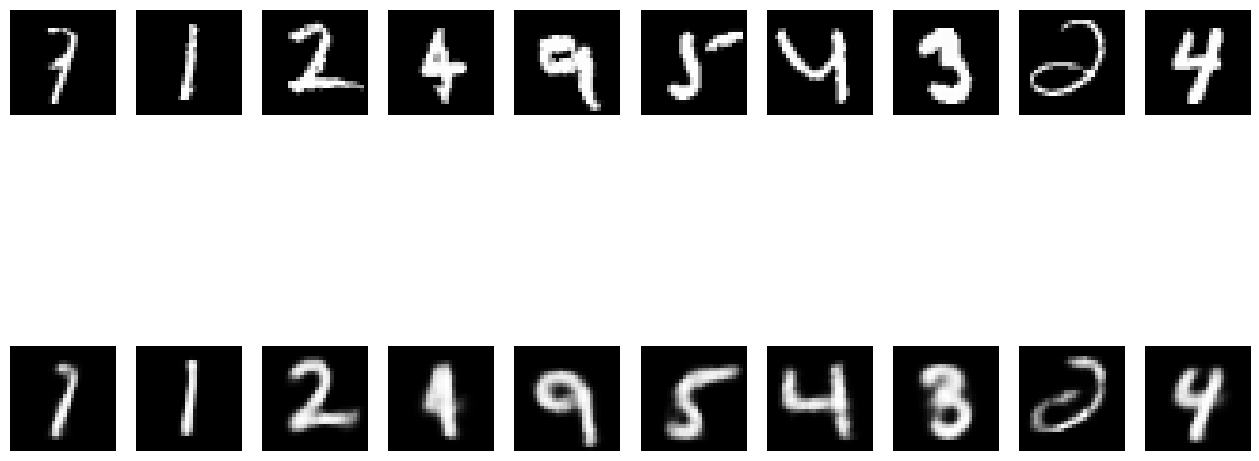

In [33]:
# Visualize imagens originais e reconstruídas
num_samples = 10
random_test_samples = np.random.randint(0, x_test.shape[0], num_samples)

plt.figure(figsize=(16,8))
for i, sample_index in enumerate(random_test_samples):
    plt.subplot(2, num_samples, i + 1)
    real_image = x_test[sample_index].reshape(28, 28)
    plt.imshow(real_image, cmap='gray')
    plt.axis('off')

    plt.subplot(2, num_samples, i + 1 + num_samples)
    encoded_image = encoder.predict(x_test[sample_index].reshape(1, 28, 28, 1))
    decoded_image = vae.predict(x_test[sample_index].reshape(1, 28, 28, 1))
    decoded_image = decoded_image.reshape(28, 28)
    plt.imshow(decoded_image, cmap='gray')
    plt.axis('off')

plt.show()
